In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE


# 2.(f)

In [3]:
'''
for this 2e, it took too long for me to run on my labtop so I did it on Colab
Thanks for understanding
'''
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
aps_train_path = '/content/drive/My Drive/data/aps_failure_training_set.csv'
aps_test_path = '/content/drive/My Drive/data/aps_failure_test_set.csv'

aps_train = pd.read_csv(aps_train_path, skiprows=20, na_values = 'na')
aps_test = pd.read_csv(aps_test_path, skiprows=20, na_values = 'na')
aps_all = pd.concat([aps_train, aps_test])

In [5]:
aps_train_X = aps_train.iloc[:, 1:]
aps_train_Y = aps_train.iloc[:, 0]
aps_test_X = aps_test.iloc[:, 1:]
aps_test_Y = aps_test.iloc[:, 0]

In [6]:

impute = SimpleImputer(missing_values=np.nan, strategy='mean')


# apply imputation 
aps_train_X = pd.DataFrame(impute.fit_transform(aps_train_X), columns=aps_train.columns[1:])
aps_test_X = pd.DataFrame(impute.fit_transform(aps_test_X), columns=aps_test.columns[1:])

In [31]:
smote = SMOTE(random_state=12345)
smote_weka_trainX, smote_weka_trainY = smote.fit_sample(aps_train_X,
                                                       aps_train_Y.replace({0.0 : 'neg', 1.0 : 'pos'}))

In [15]:
df = pd.DataFrame(smote_weka_trainX, columns = aps_train_X.columns)
df['class'] = smote_weka_trainY
df['class'] = df['class'].replace({0.0 : 'neg', 1.0 : 'pos'})

In [7]:
# save SMOTE trainning set 
smote_train_path = '/content/drive/My Drive/data/smote_weka_train.csv'
df.to_csv(smote_train_path, index=False)

In [8]:
weka_test_path = '/content/drive/My Drive/data/weka_test.csv'


In [9]:
import weka.core.jvm as jvm
import javabridge
jvm.start()
from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.7/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/weka.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [10]:
weka_loader = Loader(classname="weka.core.converters.CSVLoader")
smote_train = weka_loader.load_file(smote_train_path)
weka_test = weka_loader.load_file(weka_test_path)
smote_train.class_is_last()
weka_test.class_is_last()

In [21]:
# create LMT model and do 5-fold croos-validation
lmt = Classifier(classname='weka.classifiers.trees.LMT')
evl = Evaluation(smote_train)
evl.crossvalidate_model(classifier=lmt, data=smote_train, num_folds = 5, rnd=Random(12345))

In [22]:
# training set confusion matrix
print(evl.confusion_matrix)

[[57864.  1136.]
 [ 1169. 57831.]]


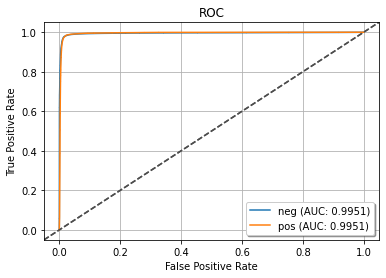

In [23]:
# plot training set ROC curve and  AUC
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [24]:
# training set report details
print(evl.summary())
print(evl.class_details())


Correctly Classified Instances      115695               98.0466 %
Incorrectly Classified Instances      2305                1.9534 %
Kappa statistic                          0.9609
Mean absolute error                      0.0335
Root mean squared error                  0.1266
Relative absolute error                  6.7002 %
Root relative squared error             25.315  %
Total Number of Instances           118000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.981    0.020    0.980      0.981    0.980      0.961    0.995     0.995     neg
                 0.980    0.019    0.981      0.980    0.980      0.961    0.995     0.992     pos
Weighted Avg.    0.980    0.020    0.980      0.980    0.980      0.961    0.995     0.994     



In [12]:
# build the classifier with training data
lmt = Classifier(classname='weka.classifiers.trees.LMT')
lmt.build_classifier(smote_train)

weka_test_predict = []
weka_test_proba = []

# make prediction 
for inst in weka_test:
    weka_test_predict.append(lmt.classify_instance(inst))
    weka_test_proba.append(lmt.distribution_for_instance(inst))

weka_test_predict = np.array(weka_test_predict).astype('str')
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_proba = np.array(weka_test_proba)

In [13]:
def model_plot(true_tag, predict, prob, title):
    conf_mat = confusion_matrix(true_tag, predict)
    print("The confusion for {} set is \n{}".format(title, conf_mat))
    acc = accuracy_score(true_tag, predict)
    print("The classification accuracy is %0.4f" % acc)
    fpr, tpr, thresholds = roc_curve(true_tag, prob[:, 1], pos_label='pos')
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(figsize=(12, 8))
    axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {} set".format(title))
    plt.show()
    plt.close()

The confusion matirx for test set is 
[[15102   523]
 [   61   314]]
The classification accuracy is 0.96350


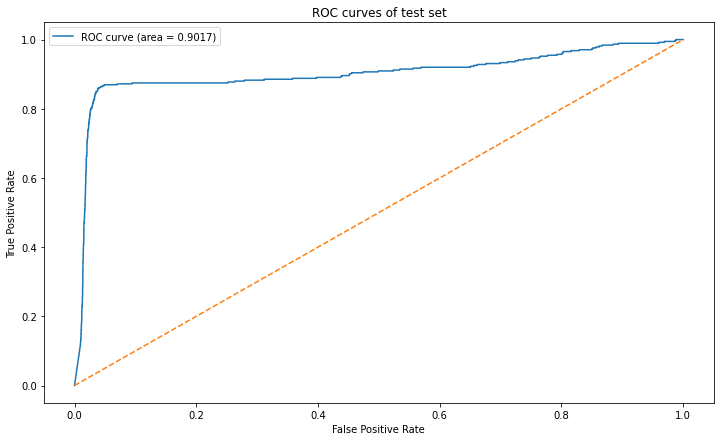

In [15]:
# test set
model_plot(aps_test_Y, weka_test_predict, weka_test_proba, 'test')

Other than CM, ROC, AUC for training and test set.
Under 5 folds CV and smote, the training set's error is 0.0195 and test set's error is 0.0365.
So after smote the eror for training set and test set both increase a lot compared to previous methods.